In [1]:
import sys
import numpy as np
import math
import ceo
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
# Telescope parameters
D = 25.5
nPx = 401
radial_order = 3
n_zern = (radial_order+1)*(radial_order+2)/2

# number of Guide Stars and off-axis position
alpha_off = np.arange(0., 60.*9., 120.)  # radius of circle where GSs are located [in arcsec]
N_OFF = alpha_off.size
zenith_angle_off  = alpha_off*math.pi/180/3600 # in radians
azimuth_angle_off = np.zeros(N_OFF)       # in degrees

# Initialize GS and WFS and GMT objects
offgs = ceo.Source("J",zenith=zenith_angle_off,azimuth=azimuth_angle_off*math.pi/180,
                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])
gmt = ceo.GMT_MX(D,nPx,M1_radial_order=radial_order,M2_radial_order=radial_order)
ps = ceo.IdealSegmentPistonSensor(gmt, offgs)

### Segment piston due to field-dependent aberrations

<matplotlib.colorbar.Colorbar instance at 0x2aeee731bcb0>

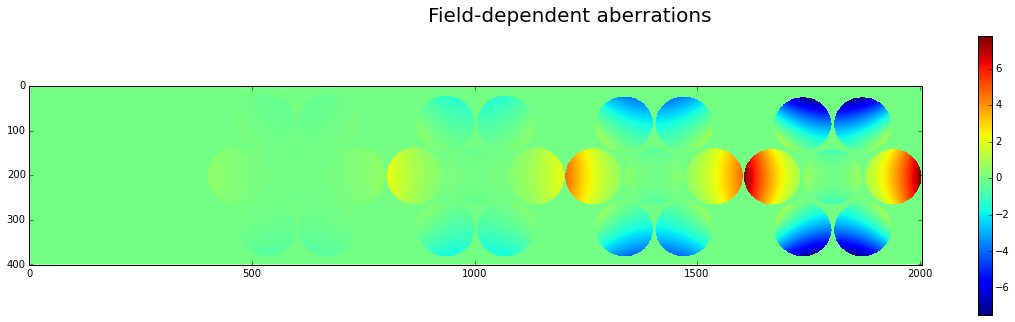

In [5]:
offgs.reset()
gmt.reset()
gmt.propagate(offgs)
fig = figure()
fig.set_size_inches(20,5)
fig.suptitle('Field-dependent aberrations', fontsize=20)
imshow(offgs.phase.host(units='micron').T, interpolation='None')
ph_fda = offgs.phase.host(units='micron').T
colorbar()

(5, 7)

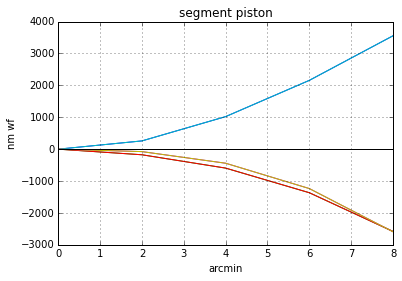

In [6]:
### Segment piston component (w.r.t central one) in field-dependent aberrations
segpist = offgs.piston('segments')*1e9 # in nm wf
for x in segpist: x -= x[6] # segment piston w.r.t central one
for x in segpist.T: plot(alpha_off/60.,x)
grid()
xlabel("arcmin")
ylabel("nm wf")
title("segment piston")
segpist.shape

### Segment piston measured by a SINGLE Idealized Piston Sensor coupled to a ON/OFF AXIS guide star

#### ON/OFF-AXIS Segment Piston Sensor: interaction and reconstruction matrices

In [5]:
# Calibrate Idealized Segment Piston Sensor Interaction Matrix (one IM at each off-axis position)
PSstroke = 200e-9 #m
gmt.reset()
Dall_M2_PS = gmt.calibrate(ps, offgs, mirror="M2", mode="segment piston", stroke=PSstroke, segment='edge')
Dall_M2_PS.shape

___ M2 ___
Segment #:1 2 3 4 5 6 
------------


(60, 6)

In [6]:
#Reform the IM in a cube-like shape for easy GS indexing
Dall_M2_PS = Dall_M2_PS.reshape((offgs.N_SRC,12,6))
Dall_M2_PS.shape

(5, 12, 6)

In [7]:
#Compute the generalized inverse of each IM
Rall_M2_PS = []
for idx in range(offgs.N_SRC): Rall_M2_PS.append( np.linalg.pinv(Dall_M2_PS[idx,:,:]) )

#### ON/OFF-AXIS Segment Piston Sensor: Segment piston estimate with a perfectly aligned telescope

In [8]:
# Get idealized piston sensor measurements for all off-axis stars
offgs.reset()
gmt.reset()
gmt.propagate(offgs)
SPSmeas = ps.piston(offgs, segment='edge')
SPSmeas.shape

(5, 12)

In [9]:
### Segment piston estimate (w.r.t central one)
SPSpist = np.zeros((offgs.N_SRC,6))
for idx in range(offgs.N_SRC): SPSpist[idx,:] = np.dot(Rall_M2_PS[idx], SPSmeas[idx,:])*1e9*2 # in nm wf

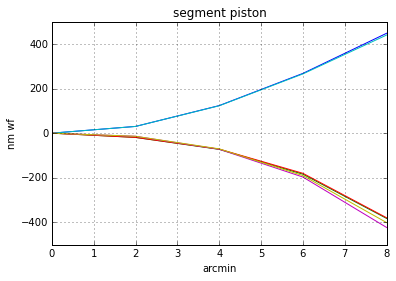

In [10]:
for x in SPSpist.T: plot(alpha_off/60.,x)
grid()
xlabel("arcmin")
ylabel("nm wf")
title("segment piston")

#### ON/OFF-AXIS Segment Piston Sensor: Segment piston estimate with ONE segment pistoned out!

<matplotlib.colorbar.Colorbar instance at 0x2b784aed3ea8>

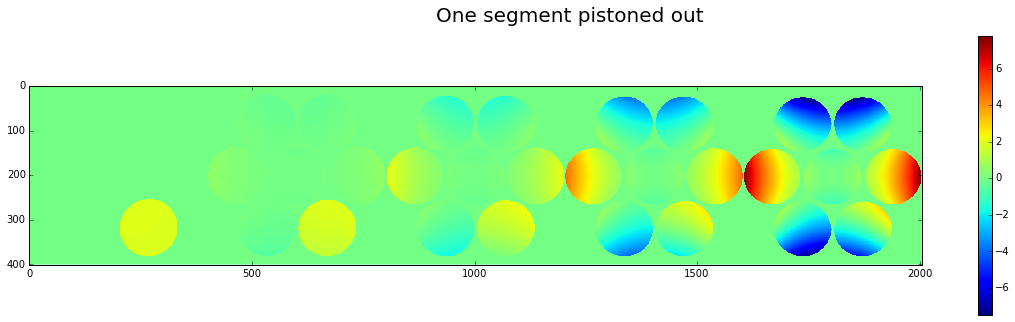

In [11]:
# Apply a known segment piston to a particular segment
myPSvalue = 1000e-9 #in m
mySeg2Idx = 2
myPosVec = np.array([0, 0, myPSvalue])
offgs.reset()
gmt.reset()
gmt.M2.update(origin=myPosVec, idx=mySeg2Idx)
gmt.propagate(offgs)
#Do some visualization:
fig = figure()
fig.set_size_inches(20,5)
fig.suptitle('One segment pistoned out', fontsize=20)
imshow(offgs.phase.host(units='micron').T, interpolation='None')
colorbar()

In [12]:
# Get idealized piston sensor measurements for all off-axis stars
SPSmeas1 = ps.piston(offgs, segment='edge')
SPSmeas1.shape

(5, 12)

In [13]:
### Segment piston estimate (w.r.t central one)
SPSpist1 = np.zeros((offgs.N_SRC,6))
for idx in range(offgs.N_SRC): SPSpist1[idx,:] = np.dot(Rall_M2_PS[idx], SPSmeas1[idx,:])*1e9*2 # in nm wf

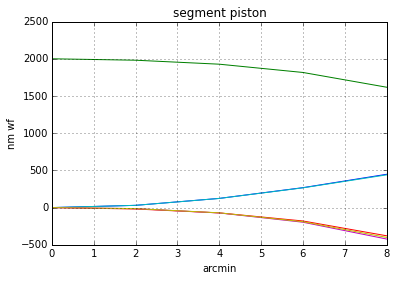

In [14]:
for x in SPSpist1.T: plot(alpha_off/60.,x)
grid()
xlabel("arcmin")
ylabel("nm wf")
title("segment piston")

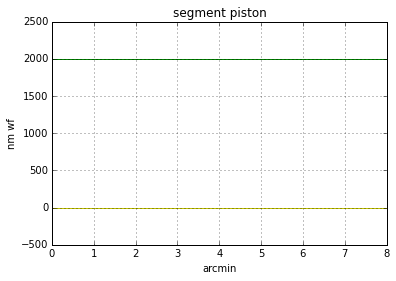

In [15]:
#Using "reference vector" to compensate for field-dependent aberrations
SPSpist1b = SPSpist1 - SPSpist
for x in SPSpist1b.T: plot(alpha_off/60.,x)
grid()
xlabel("arcmin")
ylabel("nm wf")
title("segment piston")

### ON/OFF-AXIS Segment Piston Sensor: Segment piston estimate with segment TILT on M1 and M2 compensating each other on-axis!

In [7]:
# on-axis WFS parameters
nLenslet = 25  # number of sub-apertures across the pupil
n = 16         # number of pixels per subaperture
detectorRes = 2*n*nLenslet/2

#nPx = n*nLenslet+1
print "pupil sampling:      %d pixel"%nPx

# Initialize on-axis GS and WFS
ongs = ceo.Source("I",zenith=0.,azimuth=0., rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])
wfs = ceo.ShackHartmann(nLenslet, n, D/nLenslet,N_PX_IMAGE=2*n,BIN_IMAGE=2,N_GS=1)

pupil sampling:      401 pixel


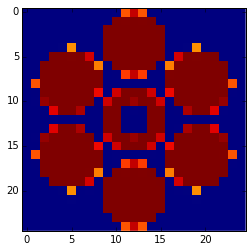

In [8]:
# Calibrate WFS slope null vector
ongs.reset()
gmt.reset()   # Telescope perfectly phased
gmt.propagate(ongs)
wfs.calibrate(ongs,0.75)
imshow(wfs.flux.host(shape=(nLenslet,nLenslet)),interpolation='none')

In [9]:
# Calibrate M2 segment TT Interaction Matrix with on-axis WFS
TTstroke = 50e-3 #arcsec
D_M2_TT = gmt.calibrate(wfs, ongs, mirror="M2", mode="segment tip-tilt", stroke=TTstroke*math.pi/180/3600)
D_M2_TT.shape

___ M2 ___
Segment #:1 2 3 4 5 6 7 
------------


(608, 14)

In [10]:
# Compute the Reconstruction Matrix
R_M2_TT = np.linalg.pinv(D_M2_TT)
R_M2_TT.shape

(14, 608)

<matplotlib.colorbar.Colorbar instance at 0x2aeeed7cffc8>

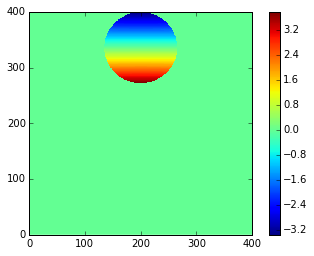

In [39]:
# Apply a known Tilt to a particular segment on M1
mySegIdx = 1
#myTTvalue = 100e-3 #arcsec
#M1TTvec = np.array([0, myTTvalue, 0])*math.pi/180/3600
gmt.reset()
#gmt.M1.update(euler_angles=M1TTvec.tolist(), idx=mySegIdx)

a_M1 = np.zeros(n_zern)   #zernike coeffs, from piston Z1 to n_zern
a_M1[2] = 1000e-9      # m RMS surf
gmt.M1.zernike.a[mySegIdx-1,:] = a_M1
gmt.M1.zernike.update()

ongs.reset()
gmt.propagate(ongs)
imshow(ongs.phase.host(units='micron'),interpolation='None',origin='lower')
colorbar()

<matplotlib.colorbar.Colorbar instance at 0x2aeeeca7e5f0>

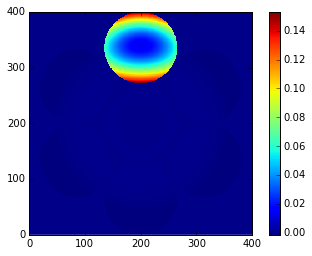

In [40]:
niter = 5
rmsval = np.zeros(niter)
myTTest1 = np.zeros(14)
for ii in range(niter):
    ongs.reset()
    gmt.propagate(ongs)
    rmsval[ii] = ongs.wavefront.rms()
    wfs.reset()
    wfs.analyze(ongs)
    slopevec = wfs.valid_slopes.host().ravel()
    #imshow(wfs.frame
    myTTest1 += np.dot(R_M2_TT, slopevec)
    myTTest = myTTest1.reshape((7,2))
    for idx in range(7): gmt.M2.update(euler_angles=[-myTTest[idx,0],-myTTest[idx,1],0], idx=idx+1)
imshow(ongs.phase.host(units='micron'),interpolation='None', origin='lower')
colorbar()

Segment 1: 
   Applied TT values on M1: 0.000000 100.000000 mas
 Estimated TT values on M2: -737.341384 0.000004 mas


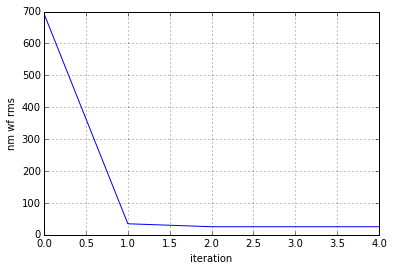

In [41]:
plot(rmsval*1e9)
grid()
xlabel('iteration')
ylabel('nm wf rms')
print "Segment %d: \n   Applied TT values on M1: %f %f mas"%(mySegIdx, M1TTvec[0]*180*3600/math.pi*1e3, M1TTvec[1]*180*3600/math.pi*1e3)
print " Estimated TT values on M2: %f %f mas"%(myTTest[mySegIdx-1,0]*180*3600/math.pi*1e3, myTTest[mySegIdx-1,1]* 180*3600/math.pi*1e3)

In [48]:
8.365*np.tan(47e-3*math.pi/180/3600)/4

4.7651730699155731e-07

In [29]:
print rmsval*1e9

[ 746.56622928   28.51549041    0.79376611    0.79315299    0.79307877]


<matplotlib.colorbar.Colorbar instance at 0x2b784bf63098>

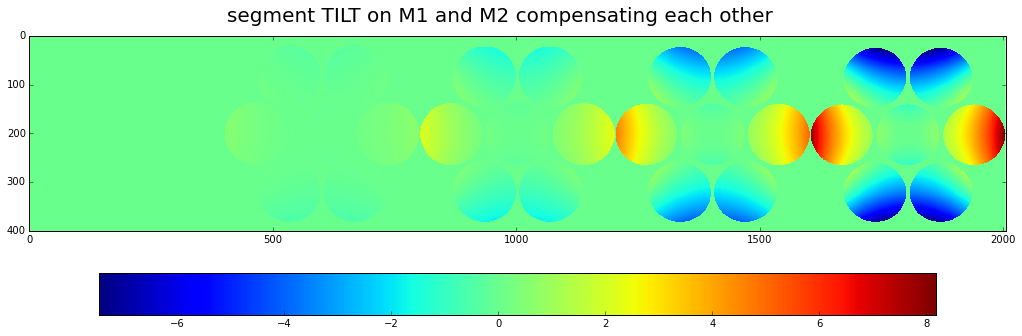

In [30]:
offgs.reset()
gmt.propagate(offgs)
#Do some visualization:
fig = figure()
fig.set_size_inches(20,5)
fig.suptitle('segment TILT on M1 and M2 compensating each other', fontsize=20)
imshow(offgs.phase.host(units='micron').T, interpolation='None')
ph_tton = offgs.phase.host(units='micron').T
colorbar(orientation='horizontal')

<matplotlib.colorbar.Colorbar instance at 0x2b784abfd170>

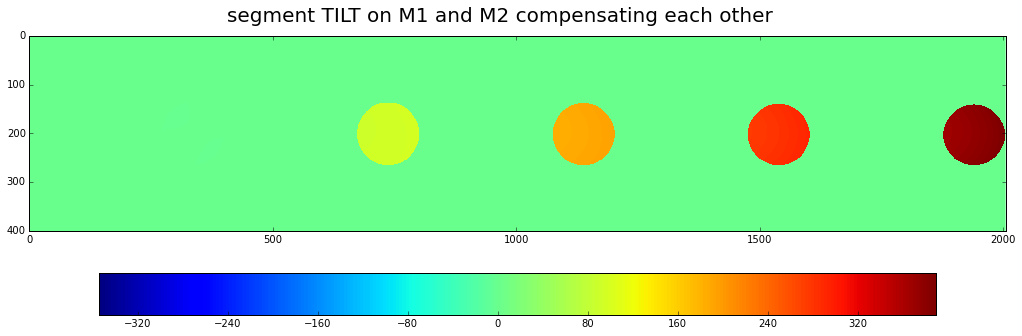

In [31]:
fig = figure()
fig.set_size_inches(20,5)
fig.suptitle('segment TILT on M1 and M2 compensating each other', fontsize=20)
imshow((ph_tton-ph_fda)*1e3, interpolation='None') # show in nm wf
colorbar(orientation='horizontal')

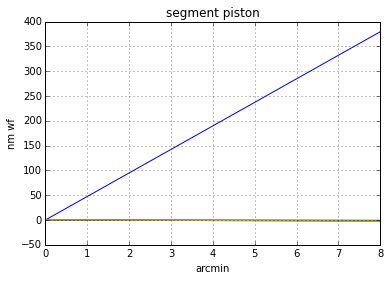

In [32]:
### Get idealized piston sensor measurements and estimates for all off-axis stars
SPSmeas2 = ps.piston(offgs, segment='edge')
### Segment piston estimate (w.r.t central one)
SPSpist2 = np.zeros((offgs.N_SRC,6))
for idx in range(offgs.N_SRC): SPSpist2[idx,:] = np.dot(Rall_M2_PS[idx], SPSmeas2[idx,:])*1e9*2 # in nm wf
### Subtract reference vector 
SPSpist2b = SPSpist2 - SPSpist
for x in SPSpist2b.T: plot(alpha_off/60.,x)
grid()
xlabel("arcmin")
ylabel("nm wf")
title("segment piston")